## 处理原始roe数据 
- 从原始roe数据获取趋势和极值点
- 将平滑刻度选成4季度，消除季节性影响，高斯模糊选择的是n=8，应该已经消除了季节性影响

In [1]:
import sys
sys.path.append("..")
import usefulFuncs as uf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy.signal as signal
from random import sample
from scipy.stats.mstats import winsorize

In [2]:
filePath = "/Users/zch/Desktop/internship/Jan14/机械roeData.xlsx"
roe = pd.read_excel(filePath)

In [3]:
roe.head()

,code,name,2000-03,2000-06,2000-09,2000-12,2001-03,2001-06,2001-09,2001-12,...,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09,2020-12
0,000008.SZ,神州高铁,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.8794,2.7954,0.1604,0.7463,1.1356,3.9001,-1.4616,-2.5378,0.7020,NaN
1,000039.SZ,中集集团,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5906,...,4.2918,3.0535,1.0623,0.7117,-0.1142,2.3391,-1.6447,1.1583,2.1542,NaN
2,000157.SZ,中联重科,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.7083,...,1.1780,1.8944,2.5903,4.1326,2.4141,2.3247,2.6003,7.0930,3.6814,NaN
3,000425.SZ,徐工机械,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.5403,1.8615,3.4380,3.9074,2.2892,1.8277,1.8240,4.2272,1.1084,NaN
4,000528.SZ,柳工,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.2561,0.7812,3.1375,3.6226,2.2035,1.3220,1.6257,4.7731,2.8909,NaN


In [4]:
roe.dropna(how="all", inplace=True, axis=1)

In [5]:
roe.head()

,code,name,2001-09,2001-12,2002-03,2002-06,2002-09,2002-12,2003-03,2003-06,...,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09
0,000008.SZ,神州高铁,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.7182,0.8794,2.7954,0.1604,0.7463,1.1356,3.9001,-1.4616,-2.5378,0.7020
1,000039.SZ,中集集团,NaN,1.5906,3.1579,6.6820,4.7204,3.1600,3.5896,7.5109,...,1.6321,4.2918,3.0535,1.0623,0.7117,-0.1142,2.3391,-1.6447,1.1583,2.1542
2,000157.SZ,中联重科,NaN,3.7083,2.0398,7.0492,2.8439,4.5008,2.6650,6.9962,...,1.2990,1.1780,1.8944,2.5903,4.1326,2.4141,2.3247,2.6003,7.0930,3.6814
3,000425.SZ,徐工机械,NaN,NaN,1.2559,3.2474,2.7717,3.1182,1.0807,5.0183,...,2.3709,1.5403,1.8615,3.4380,3.9074,2.2892,1.8277,1.8240,4.2272,1.1084
4,000528.SZ,柳工,NaN,NaN,1.6334,3.7158,5.0962,5.9681,6.7560,7.7067,...,3.2659,1.2561,0.7812,3.1375,3.6226,2.2035,1.3220,1.6257,4.7731,2.8909


In [6]:
codes = roe.code.values

In [7]:
code = "000528"
company, y = uf.getCompanyByCode(code, roe)

In [8]:
yRolling = uf.getYRolling(y, n=8, gaussian=True, center=True)

In [17]:
maxIdx, minIdx = uf.getExtreme(yRolling, order=3)

In [18]:
maximum, minimum = yRolling[maxIdx], yRolling[minIdx]

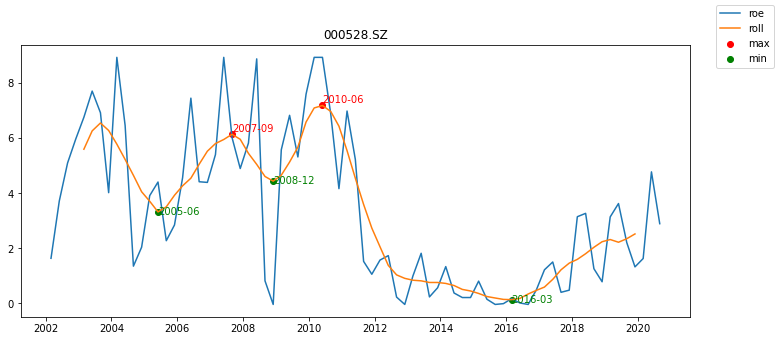

In [25]:
uf.showOne(code, temp)  # winsorized

In [19]:
minNum = 40
winsorize = True
temp = roe.copy()
# drop year with all being NaN
temp.dropna(axis=1, how="all", inplace=True)
# 至少有minNum个季度
temp = temp[temp.count(axis=1) > minNum]
# ROE 数据连续
temp = temp[temp.apply(lambda x:uf.isContinuous(x), axis=1)]
# 缩尾
if winsorize:
    temp.iloc[:, 2:] = temp.iloc[:, 2:].apply(lambda x: np.clip(x, np.nanquantile(x, 0.05), np.nanquantile(x, 0.95)), axis=1)

In [26]:
temp.to_excel("winsorizedRoe.xlsx", index=False)

## 筛选公司规则
*重新运行了代码*
- 波动性大，如何衡量？
    - 用行业平均衡量，选择超过行业平均的公司
    - 选中的公司再根据规则筛选
        - 极值点个数
        - 存在极大极小值差值超过n个标准差的个数超过m个（或者比例），n=1.5？

In [2]:
# 重新运行
filePath = "winsorizedRoe.xlsx"
roe = pd.read_excel("winsorizedRoe.xlsx")

In [33]:
roe.head()

,code,name,2001-09,2001-12,2002-03,2002-06,2002-09,2002-12,2003-03,2003-06,...,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09
0,000008.SZ,神州高铁,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.7182,0.8794,2.7954,0.1604,0.7463,1.1356,3.9001,-1.46160,-1.531215,0.7020
1,000039.SZ,中集集团,NaN,1.5906,3.1579,6.6820,4.7204,3.1600,3.5896,7.5109,...,1.6321,4.2918,3.0535,1.0623,0.7117,-0.1142,2.3391,-0.18165,1.158300,2.1542
2,000157.SZ,中联重科,NaN,3.7083,2.0398,7.0492,2.8439,4.5008,2.6650,6.9962,...,1.2990,1.1780,1.8944,2.5903,4.1326,2.4141,2.3247,2.60030,7.093000,3.6814
3,000425.SZ,徐工机械,NaN,NaN,1.2559,3.2474,2.7717,3.1182,1.0807,5.0183,...,2.3709,1.5403,1.8615,3.4380,3.9074,2.2892,1.8277,1.82400,4.227200,1.1084
4,000528.SZ,柳工,NaN,NaN,1.6334,3.7158,5.0962,5.9681,6.7560,7.7067,...,3.2659,1.2561,0.7812,3.1375,3.6226,2.2035,1.3220,1.62570,4.773100,2.8909


In [30]:
stds = []
for code in codes:
    company, y = uf.getCompanyByCode(code, roe)
    yRolling = uf.getYRolling(y)
    stds.append(np.std(yRolling,ddof=1))

In [31]:
len(stds)

144

In [34]:
avgStd = np.average(stds)

In [43]:
roeStd = roe[stds>avgStd]
len(roeStd)

45

In [44]:
roeStd.to_excel("标准差高于均值roe.xlsx", index=False)

In [82]:
roeStd.reset_index(drop=True,inplace=True)
len(roeStd)

45

In [60]:
def isGoodByRelDiff(maximum, minimum, std, n=1.5, minExtreme=4, proportion=0.5):
    '''
    Description:
    通过相对差值选择公司，极值个数不少于minExtreme，却存在超过n个std的极值差
    ---
    Params:
    maximum, Series, maximum points
    minimum, Series, minimum points
    std, float, std for yRolling
    n, float, std times
    minExtreme, int, number of minimum tolerant extreme points
    proportion, float, 极值差超过n个std的比例
    ---
    Returns:
    bool, True means good 
    '''
    minMax = pd.concat([maximum, minimum]).sort_index()
    if len(minMax)<minExtreme:
        return False
    minMaxDiff = np.abs(minMax.diff(1))  # 相邻极值点的差值
    return (minMaxDiff>=n*std).sum()>=(proportion*(len(minMax)-1))

In [73]:
codes = roeStd.code.values

In [121]:
goodOrNots = []
for code in codes:
    company, y = uf.getCompanyByCode(code, roe)
    yRolling = uf.getYRolling(y)
    maxIdx, minIdx = uf.getExtreme(yRolling)
    maximum, minimum = yRolling[maxIdx], yRolling[minIdx]
    std = np.std(yRolling, ddof=1)
    # proportion = 0.2 20个
    # proportion = 0 31个
    goodOrNots.append(isGoodByRelDiff(maximum, minimum, std, n=1.5, minExtreme=4, proportion=0.2))


In [122]:
tempCodes = roeStd[goodOrNots].code.values

In [123]:
good = roeStd[goodOrNots]
print(len(good))

24


000039.SZ 中集集团
000157.SZ 中联重科
000528.SZ 柳工
000584.SZ 哈工智能
000680.SZ 山推股份
000852.SZ 石化机械
000856.SZ 冀东装备
000976.SZ 华铁股份
002006.SZ 精功科技
002209.SZ 达意隆
300080.SZ 易成新能
300171.SZ 东富龙
600031.SH 三一重工
600169.SH 太原重工
600302.SH 标准股份
600375.SH 汉马科技
600520.SH 文一科技
600545.SH 卓郎智能
600582.SH 天地科技
600843.SH 上工申贝
600894.SH 广日股份
600984.SH 建设机械
601106.SH 中国一重
900924.SH 上工B股


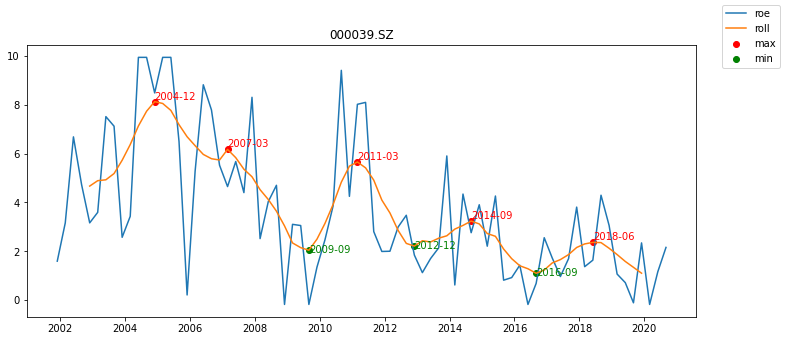

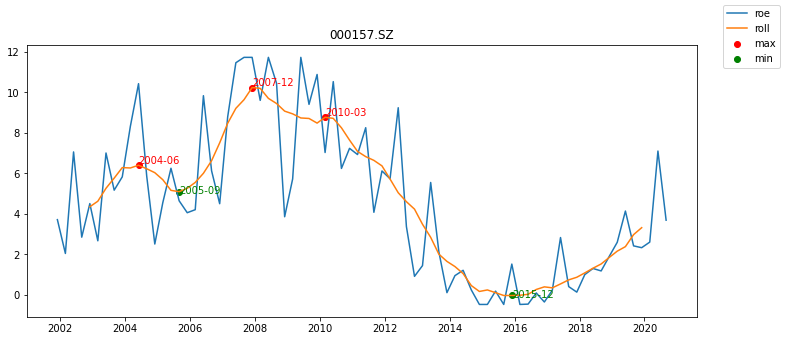

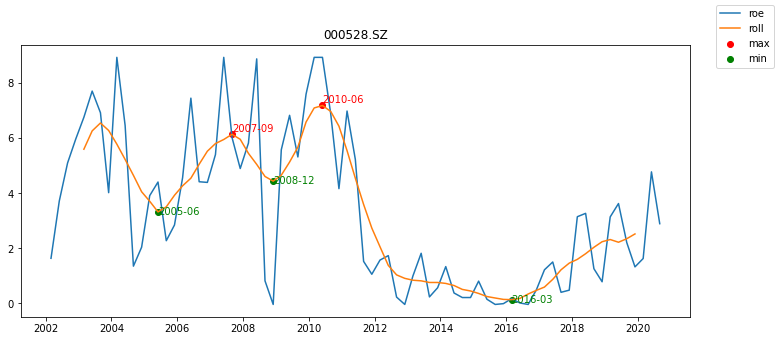

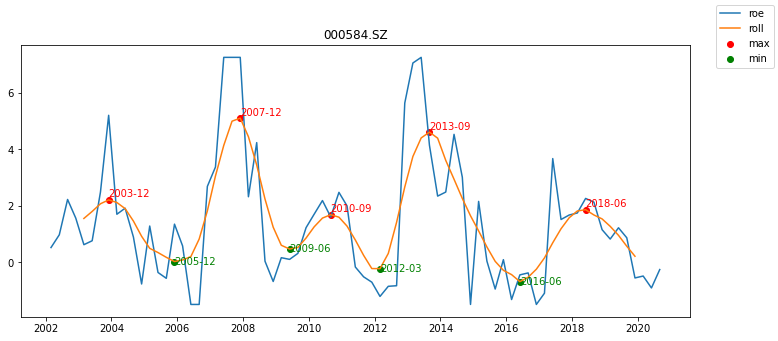

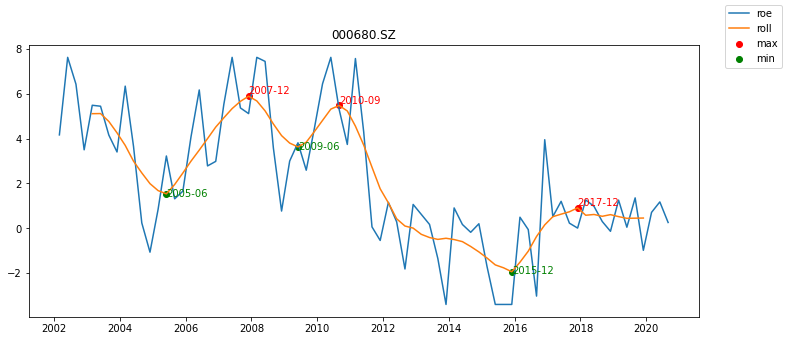

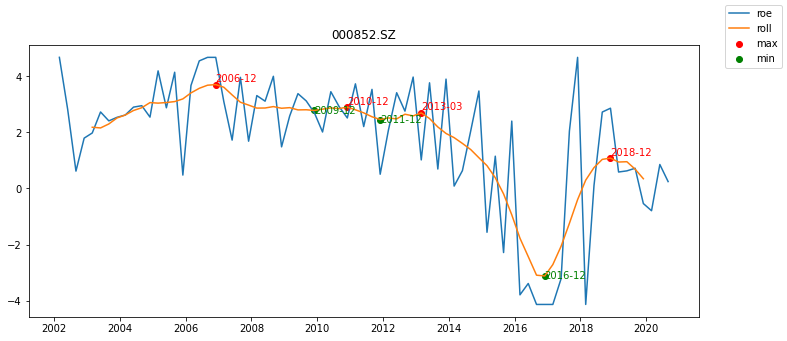

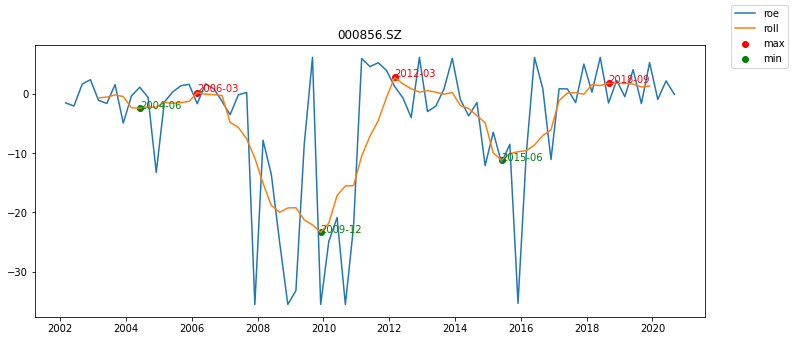

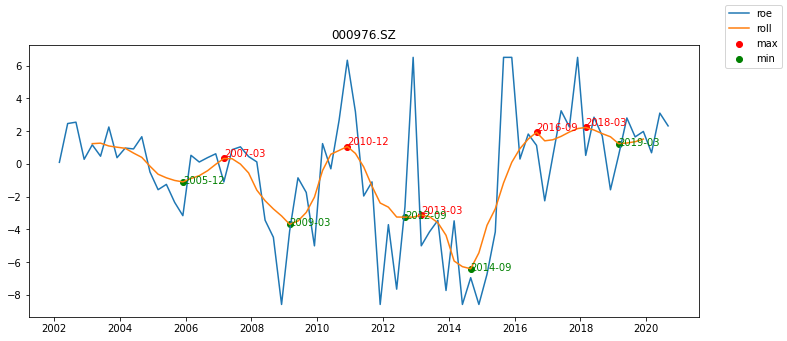

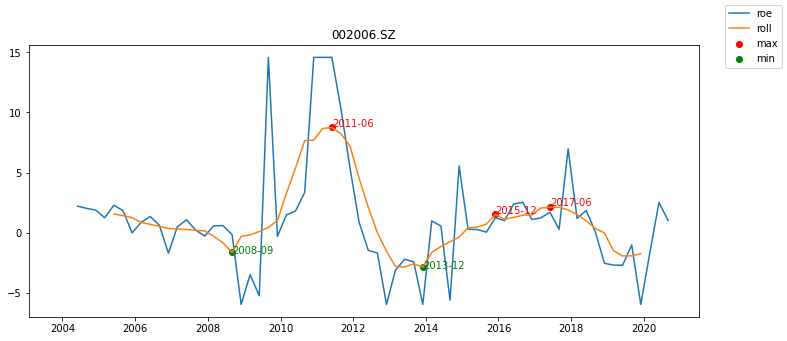

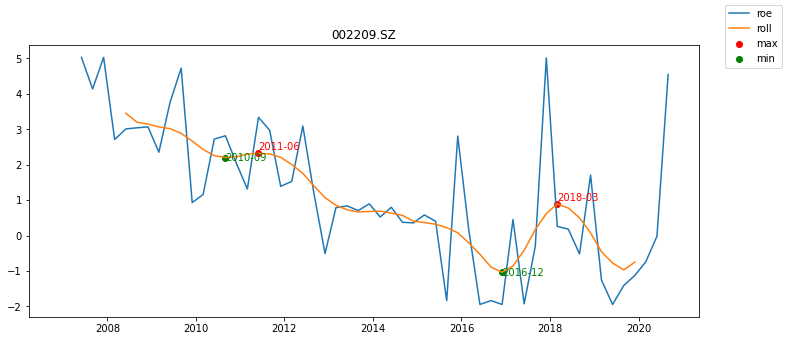

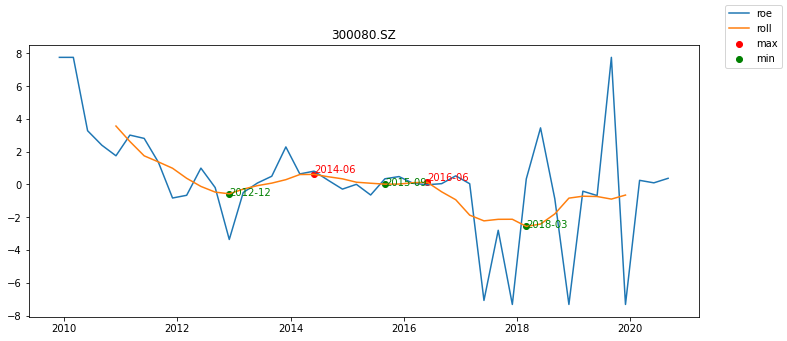

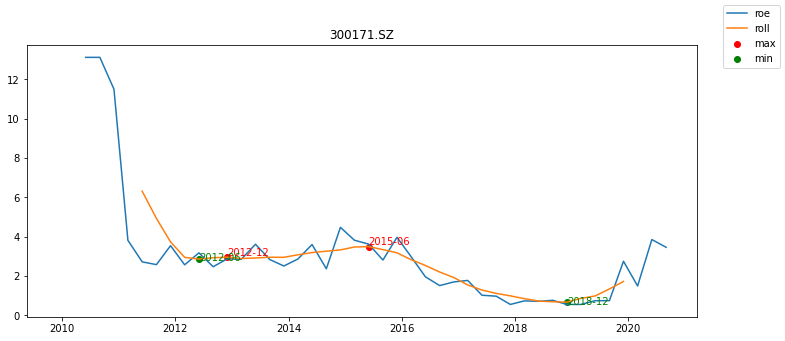

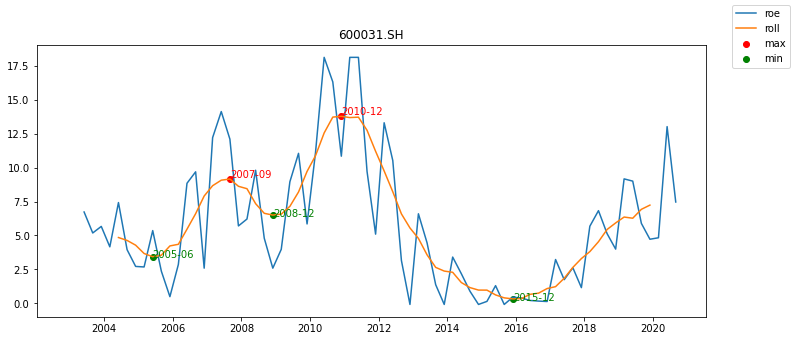

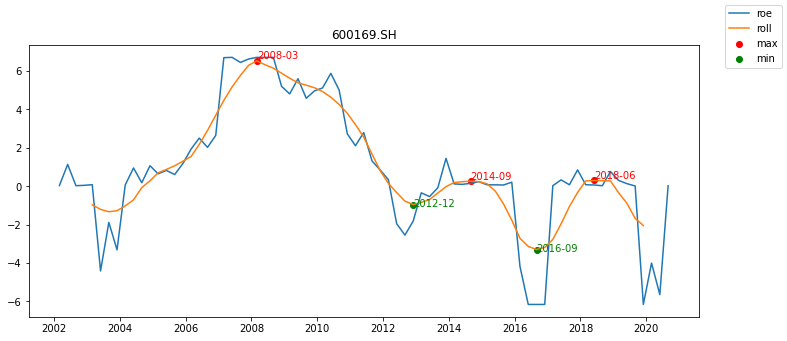

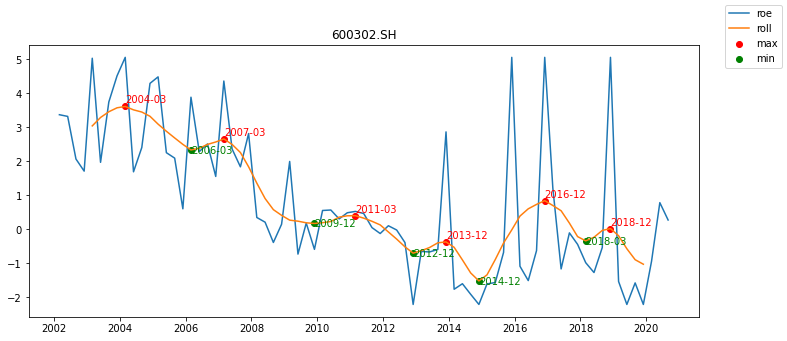

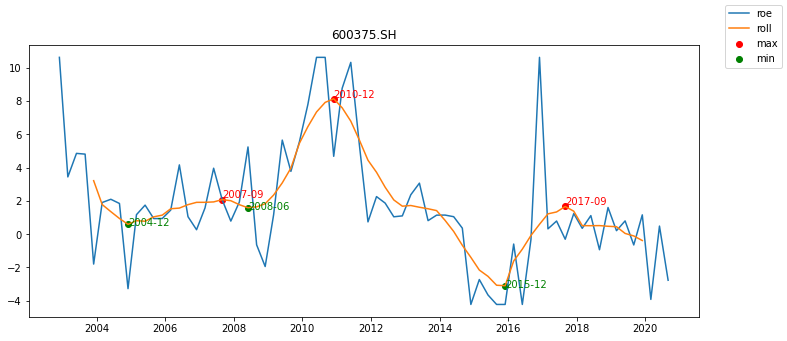

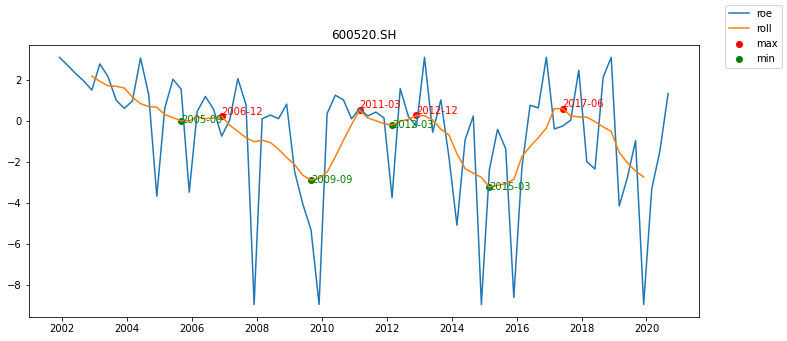

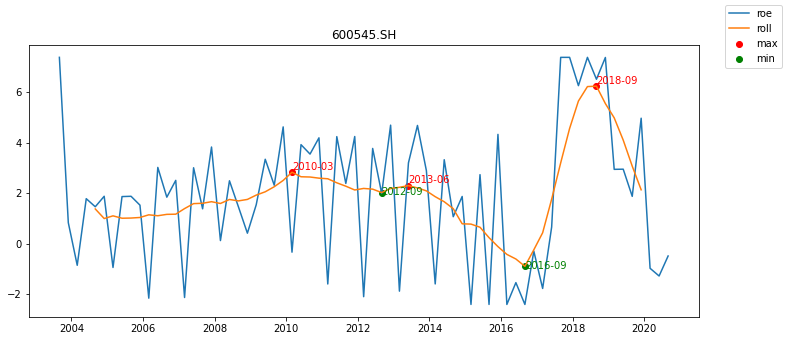

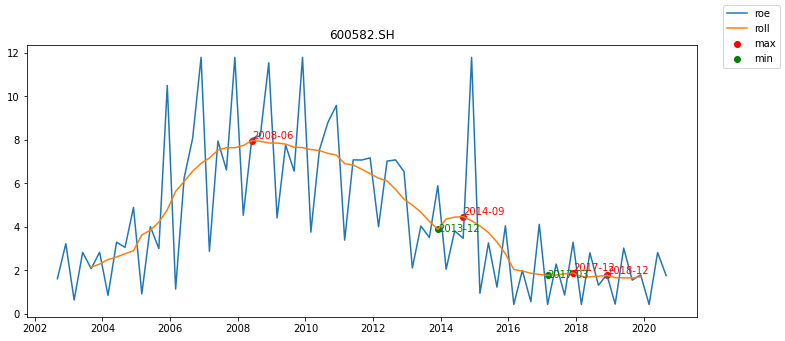

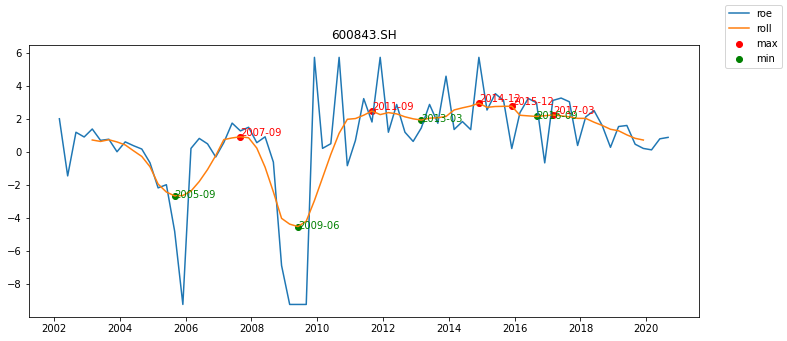

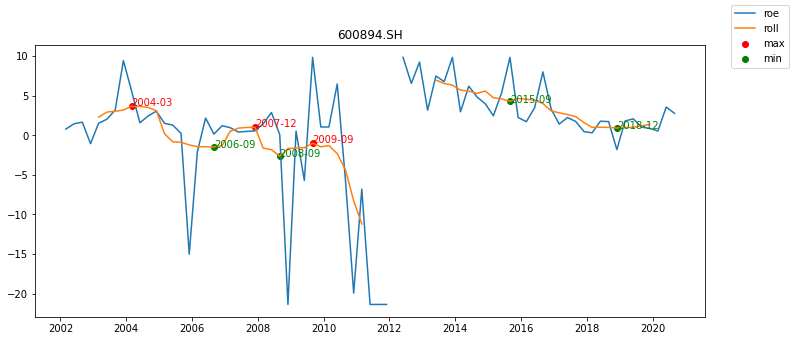

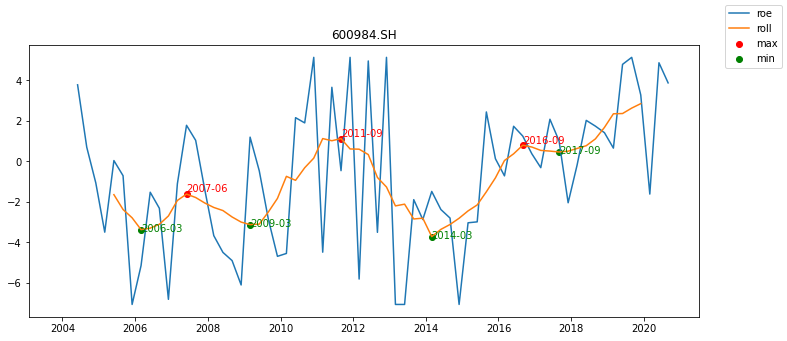

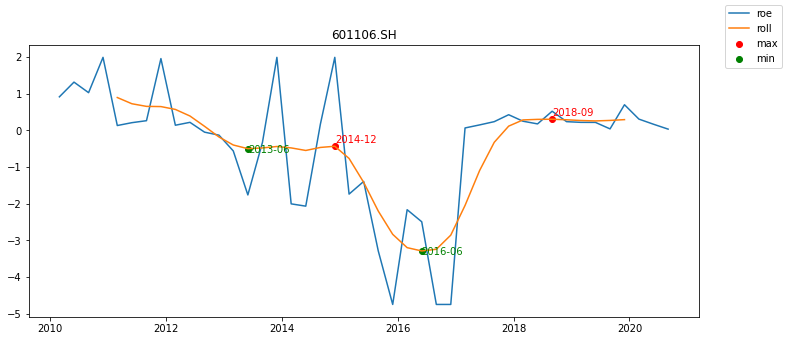

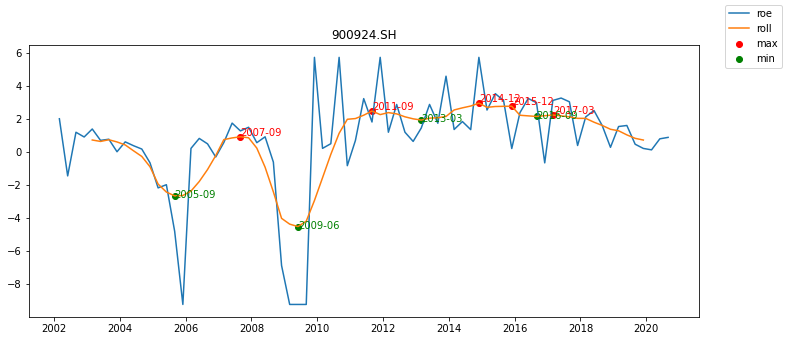

In [124]:
# 看一下效果 tempCodes sample
for code in tempCodes:
    name = uf.getNameByCode(code, good)
    print(code, name)
    # try:
    uf.showOne(code, roeStd)
    # except Exception as e:
    #     print(code)
    #     break

In [103]:
# 标记
# marked = uf.markCompanies(roeStd[])
roeStd[roeStd["code"].str.contains("900947")]

,code,name,2001-09,2001-12,2002-03,2002-06,2002-09,2002-12,2003-03,2003-06,...,2018-06,2018-09,2018-12,2019-03,2019-06,2019-09,2019-12,2020-03,2020-06,2020-09
44,900947.SH,振华B股,NaN,NaN,2.094,4.2715,1.2956,-0.3554,1.9311,4.5557,...,0.5238,0.2195,1.6455,0.6499,0.8134,0.1379,1.7725,-0.636,0.7992,1.2697


In [114]:
marked = uf.markCompanies(good)

In [116]:
# marked.to_excel("std2p02.xlsx", index=False)

In [125]:
marked2 = uf.markCompanies(good)
# marked2.to_excel("std15p02.xlsx", index=False)